In [1117]:
import torch
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

import pickle
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

#import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [1118]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [1119]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_complete.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_complete.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")


In [1120]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    # Applicazione di SelectKBest con la funzione chi2
    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    # Ottenere i punteggi e le feature selezionate
    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    # Visualizzazione delle feature selezionate e dei loro punteggi
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [1121]:
df_train 

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [1122]:
# df_labels = df_labels[106:154]
# df_train= df_train[106:154]

In [1123]:
df_labels.head()

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0


In [1124]:
column_to_number = {
    'SV1': 1,
    'SV2': 2,
    'SV3': 3,
    'SV4': 4,
}

df_labels['fault_sv'] = 0
df_labels['opening_ratio'] = 100


for index, row in df_labels.iterrows():
    for col in column_to_number.keys():
        if row[col] < 100:
            val=row[col]
            df_labels.at[index, 'fault_sv'] = column_to_number[col]
            df_labels.at[index,'opening_ratio'] = [val]
            break



In [1125]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1,0,100
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1,0,100
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1,0,100
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,0,100


In [1126]:
# X = df_train
# y = df_labels['anomaly_location']

# smote = SMOTE(k_neighbors=2,random_state=42)

# X_resampled, y_resampled = smote.fit_resample(X, y)


# df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
# df_resampled['target'] = y_resampled

In [1127]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.860683,0.947263,0.892643,0.289725,0.646085,0.396821,0.943984,0.461597,0.387633,...,0.360145,0.553568,0.647181,0.650140,0.472297,0.597727,0.981481,0.472297,0.558522,0.472943
1,1,0.852472,0.881227,0.890624,0.293799,0.640009,0.356142,0.868280,0.455896,0.385014,...,0.343869,0.587760,0.688050,0.693058,0.507478,0.644958,0.981481,0.507478,0.577813,0.511490
2,2,0.843624,0.878493,0.886027,0.298811,0.632649,0.394658,0.893893,0.451143,0.380942,...,0.324781,0.698368,0.602476,0.611104,0.626842,0.558590,1.000000,0.626842,0.414686,0.739066
3,3,0.848008,0.850933,0.881030,0.300970,0.626942,0.429939,0.912911,0.449168,0.377372,...,0.394922,0.491161,0.600616,0.601133,0.410084,0.545026,0.981481,0.410084,0.554054,0.910304
4,4,0.845165,0.867672,0.879113,0.303136,0.623305,0.428040,0.911366,0.446502,0.375677,...,0.394395,0.511471,0.598389,0.599534,0.430053,0.544344,0.018519,0.430053,0.537570,0.187546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,0.845774,0.170685,0.782153,0.000000,0.738090,0.390637,0.514795,0.819289,0.470502,...,0.674778,0.587213,1.000000,1.000000,0.506908,1.000000,0.944444,0.506908,0.923026,0.420311
173,173,0.927244,0.396663,0.817638,0.328347,0.848741,0.791386,0.165169,0.546360,0.919978,...,0.964577,1.000000,0.713938,0.733629,1.000000,0.686769,0.962963,1.000000,0.320495,0.561156
174,174,0.945257,0.509101,0.360605,0.602150,0.214549,0.584715,0.454008,0.141901,0.609891,...,0.917057,0.490124,0.310141,0.314049,0.409072,0.260226,0.944444,0.409072,0.260117,0.939214
175,175,0.811979,0.390568,0.309811,1.000000,0.251210,0.693178,0.601747,0.000000,0.798344,...,0.389906,0.301713,0.000000,0.000000,0.236099,0.000000,0.907407,0.236099,0.073649,0.312083


In [1128]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(10, 8))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('Top Features - ANOVA F-Value')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [1129]:
# df_train = df_train[106:153]
df_train=df_train.drop(columns="index")

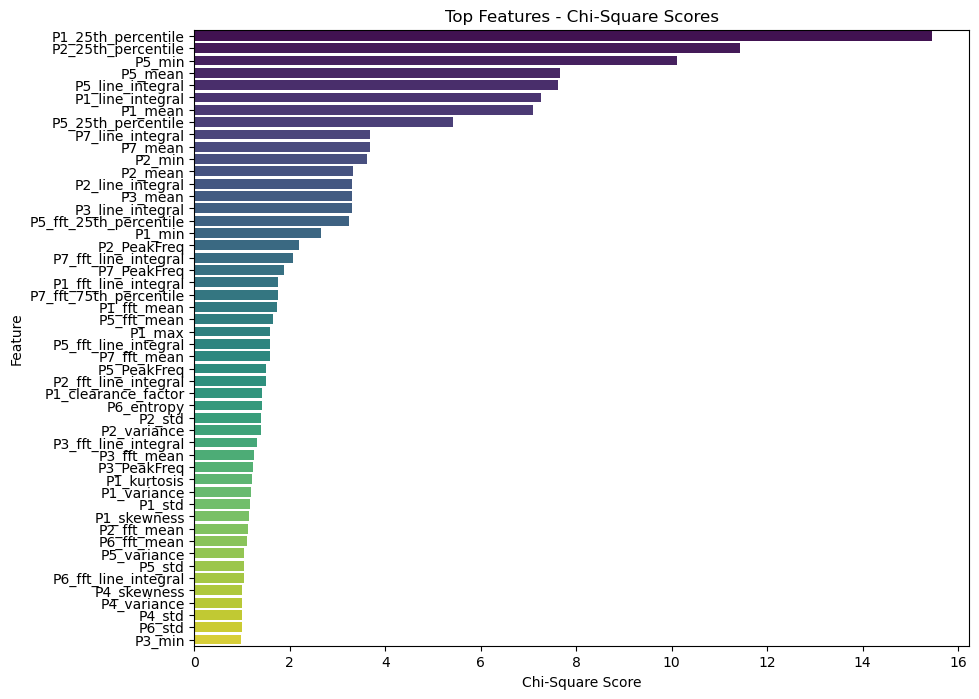

In [1130]:
features_chi2 = feature_selection_chi2(df_train,df_labels["fault_sv"],50)


In [1131]:
df_train=df_train[features_chi2]
df_test=df_test[features_chi2]

df_train = df_train[106:153]
df_labels = df_labels[106:153]

In [1132]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,fault_sv,opening_ratio
106,106,107,1,2,25,100,100,100,0,0,0,0,0,0,0,0,1,1,25
107,107,108,1,2,50,100,100,100,0,0,0,0,0,0,0,0,1,1,50
108,108,109,1,2,75,100,100,100,0,0,0,0,0,0,0,0,1,1,75
109,109,110,1,2,100,0,100,100,0,0,0,0,0,0,0,0,1,2,0
110,110,111,1,2,100,25,100,100,0,0,0,0,0,0,0,0,1,2,25
111,111,112,1,2,100,50,100,100,0,0,0,0,0,0,0,0,1,2,50
112,112,113,1,2,100,75,100,100,0,0,0,0,0,0,0,0,1,2,75
113,113,114,1,2,100,100,0,100,0,0,0,0,0,0,0,0,1,3,0
114,114,115,1,2,100,100,25,100,0,0,0,0,0,0,0,0,1,3,25
115,115,116,1,2,100,100,50,100,0,0,0,0,0,0,0,0,1,3,50


In [1133]:
df_train.head()

,P1_25th_percentile,P2_25th_percentile,P5_min,P5_mean,P5_line_integral,P1_line_integral,P1_mean,P5_25th_percentile,P7_line_integral,P7_mean,...,P2_fft_mean,P6_fft_mean,P5_variance,P5_std,P6_fft_line_integral,P4_skewness,P4_variance,P4_std,P6_std,P3_min
106,0.059154,0.066443,0.017883,0.083189,0.083007,0.128738,0.132740,0.181802,0.320633,0.321247,...,1.000000,0.456994,0.972287,0.975392,0.427534,0.297999,0.402354,0.444646,0.396195,0.075621
107,0.066919,0.070128,0.007345,0.061822,0.061677,0.134247,0.138295,0.164252,0.257495,0.258530,...,0.596912,0.535239,0.958276,0.962897,0.500542,0.411502,0.363590,0.404856,0.420014,0.086898
108,0.042085,0.056827,0.004342,0.115649,0.115446,0.136400,0.140467,0.176166,0.307069,0.307516,...,0.774235,0.496241,0.972719,0.975777,0.464417,0.436500,0.348732,0.389455,0.424340,0.156379
109,0.986978,1.000000,0.002761,0.770205,0.770074,0.902477,0.902678,0.744361,0.528827,0.529085,...,0.061257,0.391089,0.321349,0.350809,0.353033,0.143350,0.000000,0.000000,0.115602,0.225770
110,0.066142,0.060036,0.003959,0.131026,0.130730,0.134753,0.138770,0.163519,0.301240,0.301974,...,0.691017,0.454471,1.000000,1.000000,0.423741,0.557554,0.272409,0.308975,0.398437,0.076159


In [1134]:
num_locations = df_labels["fault_sv"].unique()
# print(num_locations)

X_train, X_test, y_train, y_test = train_test_split(df_train, df_labels["fault_sv"], test_size=0.1,random_state=42)

In [1135]:
y_train.head()

142    2
118    4
125    2
110    2
131    3
Name: fault_sv, dtype: int64

In [1136]:
confusion_matrices = []
models = []

for location in num_locations:

    y_binary_train = y_train == location
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_binary_train)
    
    models.append([model,location])
    
    y_pred_binary = model.predict(X_test)
    print(location)
    
    cm = confusion_matrix(y_binary_train, model.predict(X_train))
    confusion_matrices.append(cm)

  
predictions = []
for model in models:
    rf_model = model[0]
    pred = rf_model.predict(X_test)
    print(pred)
    print(y_test) 
    predictions.append(pred)


1
2
3
4
[False False False False False]
133    4
145    3
132    3
149    4
130    3
Name: fault_sv, dtype: int64
[False False False False False]
133    4
145    3
132    3
149    4
130    3
Name: fault_sv, dtype: int64
[ True  True False  True  True]
133    4
145    3
132    3
149    4
130    3
Name: fault_sv, dtype: int64
[False False False  True False]
133    4
145    3
132    3
149    4
130    3
Name: fault_sv, dtype: int64


In [1137]:
new_index_values = range(178, 224)
df_test.reset_index(drop=True, inplace=True)
df_test.index = new_index_values

In [1138]:
df_test

,P1_25th_percentile,P2_25th_percentile,P5_min,P5_mean,P5_line_integral,P1_line_integral,P1_mean,P5_25th_percentile,P7_line_integral,P7_mean,...,P2_fft_mean,P6_fft_mean,P5_variance,P5_std,P6_fft_line_integral,P4_skewness,P4_variance,P4_std,P6_std,P3_min
178,0.188521,0.039488,0.048438,0.054306,0.055201,0.079321,0.082119,0.251141,0.317581,0.317672,...,0.782915,0.455517,0.741722,0.764978,0.424450,0.337362,0.532861,0.574720,0.289921,0.414883
179,0.063933,0.046077,0.003761,0.131273,0.130994,0.143726,0.147686,0.174802,0.327472,0.327839,...,0.648990,0.475905,0.987083,0.988548,0.443338,0.562726,0.301788,0.340232,0.397197,0.083922
180,0.065567,0.056646,0.002697,0.069689,0.069548,0.148848,0.152884,0.176327,0.088054,0.089054,...,0.823154,0.561992,0.944461,0.950542,0.547249,0.460880,0.337252,0.377498,0.412882,0.062465
181,0.061874,0.042924,0.018448,0.186267,0.186084,0.152639,0.156664,0.169909,0.342598,0.340796,...,0.820866,0.525010,0.928183,0.935939,0.501192,0.463401,0.336405,0.376614,0.407569,0.062464
182,0.065674,0.056385,0.002987,0.071635,0.071468,0.146502,0.150548,0.179430,0.336929,0.338683,...,0.817657,0.615768,0.949895,0.955406,0.596078,0.458840,0.338608,0.378913,0.414448,0.062465
183,0.064793,0.058526,0.003052,0.077192,0.077004,0.138308,0.142371,0.176327,0.283785,0.284436,...,0.821007,0.600495,0.991257,0.992252,0.571655,0.446572,0.336425,0.376635,0.415606,0.062465
184,25.221792,17.693374,1.884693,86.581226,86.454785,128.022406,127.576711,15.878233,42.865908,42.944357,...,1.437725,0.519106,1.022777,1.020122,0.513672,0.178466,0.381178,0.422978,0.329753,1.543868
185,0.068747,0.059840,0.002945,0.102284,0.102089,0.137160,0.141229,0.179970,0.337361,0.338017,...,0.824442,0.414264,0.989302,0.990517,0.393264,0.450430,0.336419,0.376628,0.440321,0.062465
186,0.032575,0.162470,0.592579,0.150024,0.156484,0.052874,0.052536,0.200950,0.217366,0.213534,...,0.790444,0.322438,0.787317,0.807430,0.316113,0.541245,0.245859,0.280418,0.528571,0.054973
187,0.065113,0.053632,0.002757,0.134792,0.134594,0.141022,0.145077,0.179866,0.256888,0.257287,...,0.818709,0.516310,0.977235,0.979796,0.489204,0.454590,0.340528,0.380916,0.412147,0.062465


In [1139]:
with open(f'{path_dataframes}/index_test_fault_task2.pkl', 'rb') as file:
    fault_idx = pickle.load(file)

In [1140]:
fault_idx

array([179, 181, 188, 190, 202, 205, 211, 212, 214])

In [1141]:
df_test=df_test.loc[fault_idx]

In [1142]:
predictions = []
for model in models:
    print(model)
    rf_model = model[0]
    pred = rf_model.predict(df_test)
    predictions.append(pred)

[RandomForestClassifier(random_state=42), 1]
[RandomForestClassifier(random_state=42), 2]
[RandomForestClassifier(random_state=42), 3]
[RandomForestClassifier(random_state=42), 4]


In [1143]:
predictions

[array([False, False,  True, False, False, False, False, False, False]),
 array([ True, False, False, False, False, False, False,  True, False]),
 array([False, False, False,  True,  True, False, False, False, False]),
 array([False, False, False, False, False, False, False, False,  True])]

In [1144]:
true_indices = [np.where(arr)[0] for arr in predictions]
true_indices

[array([2]), array([0, 7]), array([3, 4]), array([8])]

1 : 188
2:179,212
3: 190,202
4:214

In [1145]:
df_test

,P1_25th_percentile,P2_25th_percentile,P5_min,P5_mean,P5_line_integral,P1_line_integral,P1_mean,P5_25th_percentile,P7_line_integral,P7_mean,...,P2_fft_mean,P6_fft_mean,P5_variance,P5_std,P6_fft_line_integral,P4_skewness,P4_variance,P4_std,P6_std,P3_min
179,0.063933,0.046077,0.003761,0.131273,0.130994,0.143726,0.147686,0.174802,0.327472,0.327839,...,0.648990,0.475905,0.987083,0.988548,0.443338,0.562726,0.301788,0.340232,0.397197,0.083922
181,0.061874,0.042924,0.018448,0.186267,0.186084,0.152639,0.156664,0.169909,0.342598,0.340796,...,0.820866,0.525010,0.928183,0.935939,0.501192,0.463401,0.336405,0.376614,0.407569,0.062464
188,0.042952,0.085695,0.055736,0.115677,0.115434,0.087379,0.091408,0.204735,0.341206,0.341728,...,0.816177,0.470934,0.970282,0.973606,0.444733,0.304520,0.571927,0.612572,0.398748,0.056473
190,0.054671,0.050078,0.042128,0.189514,0.189345,0.145353,0.149378,0.174555,0.377119,0.377549,...,0.807686,0.279370,0.933203,0.940448,0.268706,0.449805,0.339463,0.379805,0.272136,0.062464
202,0.013957,0.073382,0.009720,0.149924,0.149770,0.126740,0.131129,0.157568,0.285796,0.286104,...,0.788883,0.337512,0.870523,0.883807,0.332046,0.593227,0.583539,0.623733,0.258488,0.062465
205,0.005313,0.067720,0.003162,0.156330,0.156141,0.146665,0.150984,0.157479,0.256865,0.257497,...,0.834525,0.490697,0.908170,0.917917,0.462057,0.476332,0.578902,0.619281,0.371866,0.063448
211,-0.001175,0.067634,0.003408,0.156020,0.155822,0.120431,0.124869,0.160581,0.244929,0.245378,...,0.790231,0.500443,0.916846,0.925739,0.474531,0.506166,0.582211,0.622459,0.362929,0.107940
212,0.025815,0.097808,0.002906,0.107886,0.107772,0.181400,0.185520,0.149474,0.213805,0.216165,...,0.854138,0.531320,0.893796,0.904926,0.500663,0.487411,0.519919,0.562075,0.378419,0.070358
214,0.042131,0.097930,0.086240,0.174202,0.173991,0.092516,0.097038,0.177092,0.444065,0.444594,...,0.884159,0.354250,0.866553,0.880194,0.337708,0.533166,0.599321,0.638836,0.481058,0.062464
